In [7]:
pip install gensim

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [25]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import nltk
import time
import string
from collections import defaultdict
from collections import Counter

import re
import gensim
from gensim.parsing.preprocessing import STOPWORDS

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt

In [2]:
pip install praw

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 188 kB 9.7 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


# PART 1

### Scraping Reddit

In [3]:
import praw

In [338]:
# Create scraping agent
user_agent = 'scraper_v1'
reddit = praw.Reddit(
    client_id = 'OMjXUAKux4InvR8McNBxgw',
    client_secret = 'i0EWo3zXirfzDmyyueDcTQ16336Nuw',
    user_agent = user_agent
)

In [346]:
# create basic data structures
subreddits = ['Jokes', 'entertainment', 'sports', 'aliens']
comments_per_subredd = defaultdict(list)
#comment_scores = []

In [348]:
num_comments_to_scrape_per_subreddit = 20000
for subredd in subreddits:
    
    # start timer
    start = time.time()
    print(f'Currently scraping r/{subredd}')
    
    
    # iterate thru submissions
    for submission in reddit.subreddit(subredd).hot(limit=None):
        
        submission.comments.replace_more(limit=0) # handle MoreComments error
        # fetch comments
        
        comments = submission.comments.list()
        comments_per_subredd[subredd].extend([c.body for c in comments]) # append comment text
        #comment_scores.extend([c.score for c in comments]) # append comment score
        
        #if len(comment_scores) != len(comments_per_subredd[subredd]):
            #print('ERROR: length mismatch!')
            
        if len(comments_per_subredd[subredd]) >= num_comments_to_scrape_per_subreddit:
            break
    
    # stop timer
    end = time.time()
    print(f'number of comments scraped: {len(comments_per_subredd[subredd])}')
    print(f'Scraping time: {end-start} seconds')
    print()

Currently scraping r/Jokes
number of comments scraped: 19192
Scraping time: 1542.8148159980774 seconds
Currently scraping r/entertainment
number of comments scraped: 20445
Scraping time: 146.7462968826294 seconds
Currently scraping r/sports
number of comments scraped: 20301
Scraping time: 501.34963488578796 seconds
Currently scraping r/aliens
number of comments scraped: 20179
Scraping time: 744.7554512023926 seconds


#### Save data dictionary

In [ ]:
# open file for writing, "w" is writing
w = csv.writer(open("comms.csv", "w"))

# loop over dictionary keys and values
for key, val in comments_per_subredd.items():

    # write every key and value to file
    w.writerow([key, val])

### Data Cleaning

In [390]:
comments_per_subredd.keys()

dict_keys(['Jokes', 'entertainment', 'sports', 'aliens'])

In [391]:
subreddit = []
text = []

num_comments_limit = 15000

for sub, comments_lst in comments_per_subredd.items():
    
    text.extend(comments_lst[:num_comments_limit])
    for i in range(num_comments_limit):
        subreddit.append(sub)

In [392]:
df = pd.DataFrame()
df['text'] = text
df['subreddit'] = [word.lower() for word in subreddit]
df.head()

,text,subreddit
0,Mod: *At least this joke isn’t a repost*\n\nT...,jokes
1,"I'll have the eggs, bacon, sausage, and spam.",jokes
2,I have a question from reading the rules\n\nI ...,jokes
3,I bought a book online so I could be aware of...,jokes
4,"So first, spam. It’s a great canned meat that ...",jokes


In [393]:
# save dataframe for future access
compression_opts = dict(method='zip',
                        archive_name='comments.csv')  

df.to_csv('comments.zip', index=False,
          compression=compression_opts) 

#### Remove emojis

In [48]:
df = pd.read_csv('comments.csv')
text = df['text']
df.head()

,text,subreddit
0,Mod: *At least this joke isn’t a repost*\n\nT...,jokes
1,"I'll have the eggs, bacon, sausage, and spam.",jokes
2,I have a question from reading the rules\n\nI ...,jokes
3,I bought a book online so I could be aware of...,jokes
4,"So first, spam. It’s a great canned meat that ...",jokes


In [5]:
def removeEmojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

df['text'] = df['text'].apply(removeEmojis)

#### Remove punctuation and convert to lowercase

In [6]:
punctuation = set(string.punctuation)
def remove_punc_convert_lower(comment):
    return ''.join([c for c in comment.lower() if not c in punctuation])

df['text'] = df['text'].apply(remove_punc_convert_lower)

### EDA

In [7]:
df['subreddit'].value_counts()

jokes            15000
entertainment    15000
sports           15000
aliens           15000
Name: subreddit, dtype: int64

In [8]:
df.isna().sum()

text         0
subreddit    0
dtype: int64

AVERAGE length of comments per subreddit:


<AxesSubplot:title={'center':'AVERAGE length of comments per subreddit'}, xlabel='subreddit'>

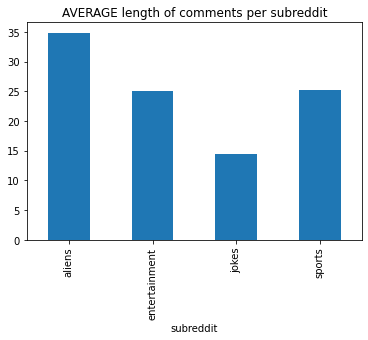

In [28]:
df['text_length'] = df['text'].apply(lambda text: len(text.split()))

print('AVERAGE length of comments per subreddit:')
df.groupby('subreddit')['text_length'].mean().plot(kind='bar', 
                                                   title='AVERAGE length of comments per subreddit')

MEDIAN length of comments per subreddit:


<AxesSubplot:title={'center':'MEDIAN length of comments per subreddit'}, xlabel='subreddit'>

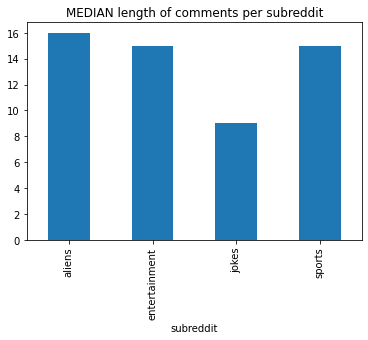

In [29]:
print('MEDIAN length of comments per subreddit:')
df.groupby('subreddit')['text_length'].median().plot(kind='bar',
                                                    title='MEDIAN length of comments per subreddit')

In [11]:
all_stopwords_gensim = STOPWORDS
def count_num_stopwords(comment):
    
    comment = comment.split()
    counts = Counter(comment)
    
    counter = 0
    for stop_word in STOPWORDS:
        counter += counts[stop_word]
    return counter
      
df['num_stopwords'] = df['text'].apply(count_num_stopwords)

AVERAGE number of stopwords in comments by subreddit


<AxesSubplot:title={'center':'AVERAGE number of stopwords in comments by subreddit'}, xlabel='subreddit'>

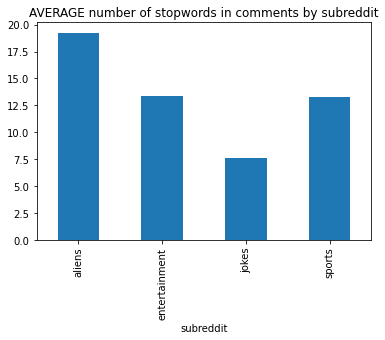

In [30]:
print('AVERAGE number of stopwords in comments by subreddit')
df.groupby('subreddit')['num_stopwords'].mean().plot(
    kind='bar',
    title='AVERAGE number of stopwords in comments by subreddit'
)

MEDIAN number of stopwords in comments by subreddit


<AxesSubplot:title={'center':'MEDIAN number of stopwords in comments by subreddit'}, xlabel='subreddit'>

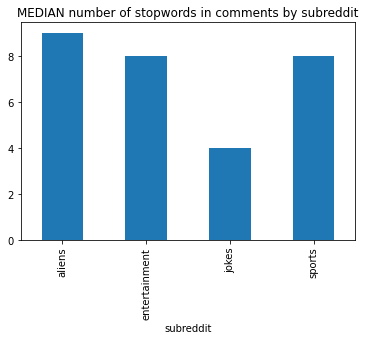

In [31]:
print('MEDIAN number of stopwords in comments by subreddit')
df.groupby('subreddit')['num_stopwords'].median().plot(
    kind='bar',
    title='MEDIAN number of stopwords in comments by subreddit'
)

AVERAGE number of unique words in comments by subreddit


<AxesSubplot:title={'center':'AVERAGE number of unique words in comments by subreddit'}, xlabel='subreddit'>

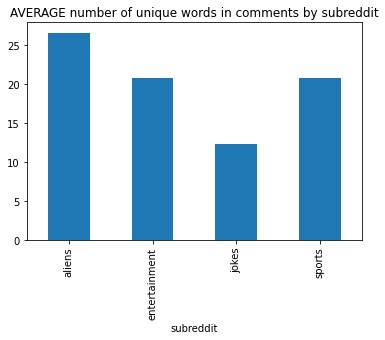

In [32]:
df['num_unique_words'] = df['text'].apply(lambda text: len(set(text.split())))

print('AVERAGE number of unique words in comments by subreddit')
df.groupby('subreddit')['num_unique_words'].mean().plot(
    kind='bar',
    title='AVERAGE number of unique words in comments by subreddit'
)

MEDIAN number of unique words in comments by subreddit


<AxesSubplot:title={'center':'MEDIAN number of unique words in comments by subreddit'}, xlabel='subreddit'>

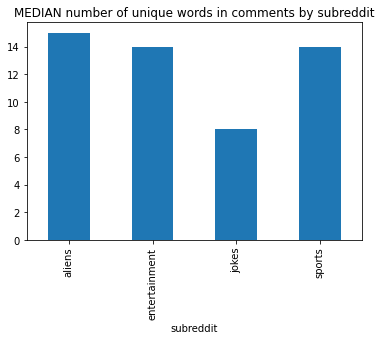

In [33]:
print('MEDIAN number of unique words in comments by subreddit')
df.groupby('subreddit')['num_unique_words'].median().plot(
    kind='bar',
    title='MEDIAN number of unique words in comments by subreddit'
)

In [36]:
# explore top 20 most common words per subreddit
common_words_per_subreddit = df.groupby("subreddit")["text"].apply(lambda x: Counter(" ".join(x).split()).most_common())
common_words_per_subreddit

subreddit
aliens           [(the, 21117), (to, 13239), (and, 11924), (of,...
entertainment    [(the, 14700), (a, 9259), (to, 8975), (and, 82...
jokes            [(the, 9388), (a, 6307), (to, 4875), (i, 4550)...
sports           [(the, 17320), (to, 9559), (a, 9184), (and, 79...
Name: text, dtype: object

In [38]:
common_words_per_subreddit['aliens'][:20]

[('the', 21117),
 ('to', 13239),
 ('and', 11924),
 ('of', 11029),
 ('a', 11007),
 ('i', 9464),
 ('that', 8562),
 ('is', 7377),
 ('it', 7127),
 ('in', 7017),
 ('they', 5477),
 ('you', 5314),
 ('are', 5117),
 ('this', 4321),
 ('we', 3983),
 ('be', 3932),
 ('have', 3787),
 ('for', 3681),
 ('but', 3505),
 ('on', 3410)]

In [42]:
common_words_per_subreddit['sports'][:20]

[('the', 17320),
 ('to', 9559),
 ('a', 9184),
 ('and', 7941),
 ('of', 6604),
 ('i', 5671),
 ('in', 5618),
 ('is', 5363),
 ('that', 5083),
 ('it', 4742),
 ('for', 3953),
 ('you', 3762),
 ('they', 3582),
 ('this', 2838),
 ('not', 2813),
 ('but', 2751),
 ('are', 2643),
 ('was', 2632),
 ('be', 2567),
 ('have', 2475)]

In [19]:
subreddits = ['Jokes', 'entertainment', 'sports', 'aliens']
subreddits

['Jokes', 'entertainment', 'sports', 'aliens']

In [20]:
# explore common words per subreddit EXCLUDING stopwords
subredds = list(df['subreddit'].unique())
d = {}

for sub in subredds:
    d[sub] = [tup for tup in common_words_per_subreddit[sub] if tup[0] not in all_stopwords_gensim]

In [21]:
for sub in subredds:
    print(f'TOP 20 most common words (excluding stopwords) in r/{sub}')
    print(d[sub][:20])
    print('/n')

TOP 20 most common words (excluding stopwords) in r/jokes
[('joke', 1339), ('like', 885), ('people', 639), ('dont', 601), ('chuck', 539), ('im', 524), ('norris', 496), ('know', 490), ('think', 450), ('thats', 433), ('good', 429), ('time', 421), ('got', 404), ('said', 370), ('man', 363), ('it’s', 308), ('funny', 308), ('way', 293), ('says', 291), ('thought', 288)]
/n
TOP 20 most common words (excluding stopwords) in r/entertainment
[('like', 2327), ('people', 2022), ('it’s', 1249), ('think', 1133), ('movie', 1058), ('good', 757), ('know', 748), ('don’t', 734), ('time', 705), ('i’m', 620), ('way', 559), ('movies', 553), ('dont', 542), ('going', 506), ('said', 506), ('that’s', 503), ('he’s', 493), ('right', 492), ('shit', 482), ('want', 472)]
/n
TOP 20 most common words (excluding stopwords) in r/sports
[('like', 1739), ('people', 1625), ('world', 1392), ('qatar', 1033), ('it’s', 981), ('think', 910), ('team', 910), ('cup', 905), ('game', 903), ('dont', 797), ('good', 755), ('fifa', 754),

In [22]:
# number of emojis

def countEmojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    
    return len(re.findall(emoj, data))

df['original_text'] = text
df['num_emojis_in_original_text'] = df['original_text'].apply(countEmojis)

AVERAGE number of emojis in comments by subreddit


<AxesSubplot:title={'center':'AVERAGE number of emojis in comments by subreddit'}, xlabel='subreddit'>

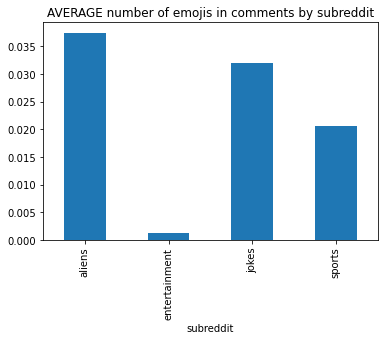

In [45]:
print('AVERAGE number of emojis in comments by subreddit')
df.groupby('subreddit')['num_emojis_in_original_text'].mean().plot(
    kind='bar',
    title='AVERAGE number of emojis in comments by subreddit'
)

In [24]:
df['has_emojis'] = df['num_emojis_in_original_text'].apply(lambda number: number != 0)
df['has_emojis'].value_counts()

False    58765
True      1235
Name: has_emojis, dtype: int64

In [37]:
df.groupby('subreddit')['has_emojis'].mean()

subreddit
aliens           0.033867
entertainment    0.000533
jokes            0.030133
sports           0.017800
Name: has_emojis, dtype: float64

# Part 2

### Feature Generation

In [38]:
wordCount = defaultdict(int)
for sentence in list(df['text']):
    for word in sentence.split():
        wordCount[word] += 1

In [39]:
counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

In [40]:
counts_no_stopwords = [tup for tup in counts if tup[1] not in all_stopwords_gensim]

In [41]:
NW = 2000
words = [x[1] for x in counts[:NW]]

wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

In [42]:
words_no_stop = [x[1] for x in counts_no_stopwords[:NW]]
wordId_no_stop = dict(zip(words_no_stop, range(len(words_no_stop))))
wordSet_no_stop = set(words_no_stop)

In [43]:
def generate_feat_vector(comment):
    
    all_features = []
    
    # Feature 0: Bag of Words (BoW)
    vec_1 = [0]*len(words)

    for word in comment.split():
        if word in wordSet:
            vec_1[wordId[word]] += 1

    all_features.append(vec_1)
    
    # Feature 1: Bag of Words (EXCLUDING stopwords)
    vec_2 = [0]*len(words_no_stop)

    for word in comment.split():
        if word in wordSet_no_stop:
            vec_2[wordId_no_stop[word]] += 1
    
    all_features.append(vec_2)
    
    # Feature 2: Number of words
    num_words = len(comment.split())
    all_features.append([num_words])
    
    # Feature 3: Number of stopwords
    num_stopwords = count_num_stopwords(comment)
    all_features.append([num_stopwords])
    
    # Feature 4: Ratio of stopwords:total_num_words
    ratio = 0
    if num_words != 0:
        ratio = num_stopwords/num_words
    
    all_features.append([ratio])
    
    # Feature 5: Number of unique words
    num_unique_words = len(set(comment.split()))
    all_features.append([num_unique_words])

    indicies_to_features = {
        '0': 'BoW (normal)',
        '1': 'BoW (excluding stopwords)',
        '2': 'Number of words',
        '3': 'Number of stopwords',
        '4': 'Ratio of stopwords to total_num_words',
        '5': 'Number of unique words'
    }
    
    desired_features = [1,4] # customize this list by referencing the dictionary above to decide which features to include
    
    feat = []
    for feat_index in desired_features:
        #return all_features[feat_index]
        feat.extend(all_features[feat_index])

    #feat.append(1)
    
    return feat

In [44]:
df_shuffled = df.sample(frac=1)
X = list(df_shuffled['text'].apply(generate_feat_vector))
y = list(df_shuffled['subreddit'])

# create train-validation split
train_size = 8
Xtrain = X[:train_size*len(X)//10]
ytrain = y[:train_size*len(y)//10]
Xvalid = X[train_size*len(X)//10:]
yvalid = y[train_size*len(y)//10:]

In [ ]:
c = 1
mod = LogisticRegression(C=c,max_iter=1000)
mod.fit(Xtrain, ytrain)
pred_train = mod.predict(Xtrain)
correct_train = pred_train == ytrain
print(f'Training accuracy: {sum(correct_train) / len(correct_train)}')

pred = mod.predict(Xvalid)
correct = pred == yvalid
print(f'Validation accuracy: {sum(correct) / len(correct)}')

### Model Selection, Tuning, and Evaluation

In [689]:
# "model_name: hyperparameters" dictionary

clf_hyperparameters = {
    "Linear SVM": {
        'C': [0.05, 0.5, 1]
    },
    "RBF SVM":  {
        'C': [0.1, 0.5, 1]
    },
    "Logistic Regression":  {
        'C':[10**-2, 10**-1, 1, 10]
    },
    "Naive Bayes":  {
        'var_smoothing': list(np.logspace(0,-4, num=10))
    }
}

In [691]:
model_names = []
params = []
train_accuracies = []
valid_accuracies = []

# ****** Logistic Regression ******

name = 'Logistic Regression'
start = time.time()

print(f'Currently tuning: {name}')

for c in clf_hyperparameters[name]['C']:
    model = LogisticRegression(C=c, max_iter=1000)
    params.append(f'C={c}')

    model.fit(Xtrain, ytrain)
    
    # compute training acc
    train_preds = model.predict(Xtrain)
    correct = train_preds == ytrain
    train_acc = sum(correct) / len(correct)
    train_accuracies.append(train_acc)

    # compute valid acc
    model.fit(Xvalid, yvalid)
    valid_preds = model.predict(Xvalid)
    correct = valid_preds == yvalid
    valid_acc = sum(correct) / len(correct)
    valid_accuracies.append(valid_acc)
    
    model_names.append(name)
    
end = time.time()
print('parameter tuning complete')
print(f'tuning time: {end-start} seconds')
print('\n')
    

# ****** Linear SVM ******
"""
name = 'Linear SVM'
start = time.time()
print(f'Currently tuning: {name}')

for c in clf_hyperparameters[name]['C']:
    model = SVC(kernel="linear", C=c)
    params.append(f'C={c}')

    model.fit(Xtrain, ytrain)
    train_preds = model.predict(Xtrain)
    correct = train_preds == ytrain
    train_acc = sum(correct) / len(correct)
    train_accuracies.append(train_acc)

    model.fit(Xvalid, yvalid)
    valid_preds = model.predict(Xvalid)
    correct = valid_preds == yvalid
    valid_acc = sum(correct) / len(correct)
    valid_accuracies.append(valid_acc)
    
    model_names.append(name)
    
end = time.time()
print('parameter tuning complete')
print(f'tuning time: {end-start} seconds')
print('\n')"""


# ****** RBF SVM ******

name = 'RBF SVM'
start = time.time()
print(f'Currently tuning: {name}')

for c in clf_hyperparameters[name]['C']:
    model = SVC(C=c)
    params.append(f'C={c}')

    model.fit(Xtrain, ytrain)
    train_preds = model.predict(Xtrain)
    correct = train_preds == ytrain
    train_acc = sum(correct) / len(correct)
    train_accuracies.append(train_acc)

    model.fit(Xvalid, yvalid)
    valid_preds = model.predict(Xvalid)
    correct = valid_preds == yvalid
    valid_acc = sum(correct) / len(correct)
    valid_accuracies.append(valid_acc)
    
    model_names.append(name)
    
end = time.time()
print('parameter tuning complete')
print(f'tuning time: {end-start} seconds')
print('\n')

# ****** Naive Bayes ******

name = 'Naive Bayes'
start = time.time()
print(f'Currently tuning: {name}')

for var in clf_hyperparameters[name]['var_smoothing']:
    model = Navie(var_smoothing = var)
    params.append(f'var_smoothing={var}')

    model.fit(Xtrain, ytrain)
    train_preds = model.predict(Xtrain)
    correct = train_preds == ytrain
    train_acc = sum(correct) / len(correct)
    train_accuracies.append(train_acc)

    model.fit(Xvalid, yvalid)
    valid_preds = model.predict(Xvalid)
    correct = valid_preds == yvalid
    valid_acc = sum(correct) / len(correct)
    valid_accuracies.append(valid_acc)
    
    model_names.append(name)
    
end = time.time()
print('parameter tuning complete')
print(f'tuning time: {end-start} seconds')
print('\n')

Currently tuning: Logistic Regression
parameter tuning complete
tuning time: 281.4314830303192 seconds


Currently tuning: RBF SVM


KeyboardInterrupt: 

In [ ]:
evaluation_df = pd.DataFrame()
evaluation_df['Model Name'] = model_names
evaluation_df['Parameters'] = params
evaluation_df['Training Accuracy'] = train_accuracies
evaluation_df['Validation Accuracy'] = valid_accuracies
evaluation_df

In [ ]:
evaluation_df.sort_values(by='Validation Accuracy', ascending=False)